# Bank Churn

- https://www.kaggle.com/competitions/playground-series-s4e1/overview
- Predicting whether a bank customer continues with their account or closes it.
    - Predicting Exited status based on a combination of categorical and numerical features of a bank customer.

# Data Understanding

- Check number of datapoints and features
- Features: categorical or numerical
- Missing values, duplicates, outliers
    - Outlier: 1.5IQR +/- Q3/Q1 respectively
- Table summarizing dataset information: 
    - categorical/numerical
    - class/range
    - number of missing values
    - number of outliers
    - if categorical, whether imbalanced

Note: Table summary excludes id, CustomerId, and Surname because those columns are identifying columns and not features to be used in prediction model.

In [35]:
#initial libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [70]:
#loading the dataset
train=pd.read_csv('train.csv')

In [91]:
train.shape

(165034, 14)

In [54]:
#checking the first 5 rows of the train dataset
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Glancing at the dataset:
- Numerical and categorical features
    - Some categorical features are already encoded (HasCrCard, IsActiveMember)
    - Others will need to be encoded (Geography, Gender)
- Target variable = Exited
    - Already encoded; 0=Retained, 1=Exited
- First 3 features are identifiers, will be dropped to prevent ML algorithm from merely learning the dataset
- Scale of numerical columns differ, will need to normalize

In [4]:
#checking the shape of train df (number of data points and features)
train.shape

(165034, 14)

In [5]:
#checking features dtypes
train.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
#more information regarding train df
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
#checking missing values; 
#also shown in the .info() table above since non-null count matches number of rows stated in .shape
train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
#checking for duplicates
train.duplicated().sum()

0

In [71]:
#summary table; feature categorization (categorical or numerical)

#dropping first 3 columns
df=train.iloc[:,3:]

#empty list to hold descriptor for each feature
feat_cat=[]

#iterating through all columns to categorize them
for col in df.columns:
    #column has object dtype -> categorical feature
    if df[col].dtype==object:
        feat_cat.append('Categorical')
    else:
        #if the number of unique values < 5 -> categorical
        if df[col].unique().sum()<5:
            feat_cat.append('Categorical')
        #all other columns must be numerical
        else:
            feat_cat.append('Numerical')

#expecting a list of 11 items
feat_cat

['Numerical',
 'Categorical',
 'Categorical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Numerical',
 'Categorical',
 'Categorical',
 'Numerical',
 'Categorical']

In [10]:
#summary table; values

#empty list to hold values for each feature
vals=[]

#iterating through all columns to get unique values for each
for col in df.columns:
    #column has object dtype -> categorical feature; use .unique() to get values
    if df[col].dtype==object:
        uni_vals=df[col].unique().tolist()
        vals.append(uni_vals)
    else:
        #if the number of unique values < 5 -> categorical; use .unique() to get values
        if df[col].unique().sum()<5:
            uni_vals=df[col].unique().tolist()
            vals.append(uni_vals)
        #all other columns must be numerical; get range of values
        else:
            col_range=df[col].max()-df[col].min()
            vals.append(col_range)

#checking values list; whether list of unique values or a range should correspond to cat/num denotation
vals

[500,
 ['France', 'Spain', 'Germany'],
 ['Male', 'Female'],
 74.0,
 10,
 250898.09,
 3,
 [1.0, 0.0],
 [0.0, 1.0],
 199980.90000000002,
 [0, 1]]

In [11]:
#table summary; missing values

#empty list to hold missing values count
na_count=[]

#iterating through all columns to get number of missing values
for col in df.columns:
    na_count.append(df[col].isnull().sum())

#expecting all 0
na_count

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
#table summary; outliers

#function to count outliers
def count_outliers(dataset):
    #setup for nice table output
    cols=[]
    out_count=[]
    out_perc=[]

    #iterating through columns to find number of outliers
    for col in dataset.columns:
        cols.append(col)
        #categorical column, put N/A
        if df[col].dtype==object:
            out_count.append('N/A')
            out_perc.append('N/A')
        #categorical column, put N/A
        elif df[col].unique().sum()<5:
            out_count.append('N/A')
            out_perc.append('N/A')
        else:
            outlier_count=0
            q1=dataset[col].quantile(0.25)
            q3=dataset[col].quantile(0.75)
            IQR=q3-q1
            lower=q1-(1.5*IQR)
            upper=q3+(1.5*IQR)
            for val in dataset[col]:
                if val<lower or val>upper:
                    outlier_count+=1
            out_count.append(outlier_count)
            out_perc.append(outlier_count/len(dataset)*100)

    return cols, out_count, out_perc
  
FeatureNames,outliers,outliers_perc=count_outliers(df)
print(FeatureNames)
outliers

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


[253, 'N/A', 'N/A', 6394, 0, 0, 475, 'N/A', 'N/A', 0, 'N/A']

In [13]:
#summary table
sumtab={
    'Features':FeatureNames,
    'Column Type':feat_cat,
    'Values/Range':vals,
    'NA Count':na_count,
    'Outliers': outliers,
    'Outliers %': outliers_perc
}

sumtab=pd.DataFrame(sumtab)
sumtab.set_index('Features',inplace=True)
sumtab


,Column Type,Values/Range,NA Count,Outliers,Outliers %
Features,,,,,
CreditScore,Numerical,500,0,253,0.153302
Geography,Categorical,"[France, Spain, Germany]",0,N/A,N/A
Gender,Categorical,"[Male, Female]",0,N/A,N/A
Age,Numerical,74.0,0,6394,3.874353
Tenure,Numerical,10,0,0,0.0
Balance,Numerical,250898.09,0,0,0.0
NumOfProducts,Numerical,3,0,475,0.287819
HasCrCard,Categorical,"[1.0, 0.0]",0,N/A,N/A
IsActiveMember,Categorical,"[0.0, 1.0]",0,N/A,N/A


Notes:
- Fairly good mix of numerical and categorical features (6 and 4 respectively)
- No missing values
- Outliers only make up a small percentage of the dataset
    - Only found in 3 features (CreditScore, Age, NumOfProducts)

In [14]:
#looking at statistical summary of numerical columns; does include categorical columns that are encoded
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Notes:
- CreditScore
    - Given min/max is 350/850 respectively, outliers are not impossible values
- Age
    - Min/max is 18/92 respectively, outliers are not impossible values
    - Range falls within expected/understandable values (age of majority as min and fairly old age, 92, as max since one usually has a bank account until death)
- Tenure
    - Looks like it would be a normal distribution based on quantile values + min/max
- NumOfProducts
    - Looks like the feature would actually be better classified as a categorical feature than a numerical feature
- EstimatedSalary
    - Min value of 11.58 looks more like hourly wage while max value of 199992.48 looks like annual salary
    - Surprised, that small values like 11.58 were not considered outliers using IQR method

# Data Visualization

In [24]:
#function that iterates through specified columns to create histogram
def compare_distributions(df,column_name,selections,**kwargs): #function allows for additional arguments '**kwargs' so that one can include all options found in 'plt.hist()'
    #looping through each key/value pair from selections
    for label,selection in selections.items(): 
        _=plt.hist(df[selection][column_name],label=label,**kwargs) #plotting histogram of selected feature and column
    
    _=plt.legend() #inclusion of legend

#function that iterates through specified columns to create a scatterplot
def compare_scatter(df,x_var_name,y_var_name,selections,make_legend=True,**kwargs) :
    #looping through each key/value pair from selections
    for label,selection in selections.items():   
        _=plt.scatter(df[selection][x_var_name],df[selection][y_var_name],label=label,**kwargs) #scatterplot of each selection

    _=plt.xlabel(x_var_name) #labeling
    _=plt.ylabel(y_var_name)

    if make_legend:
        _=plt.legend() #inclusion of legend depending on whether 'make_legend' argument is true/false

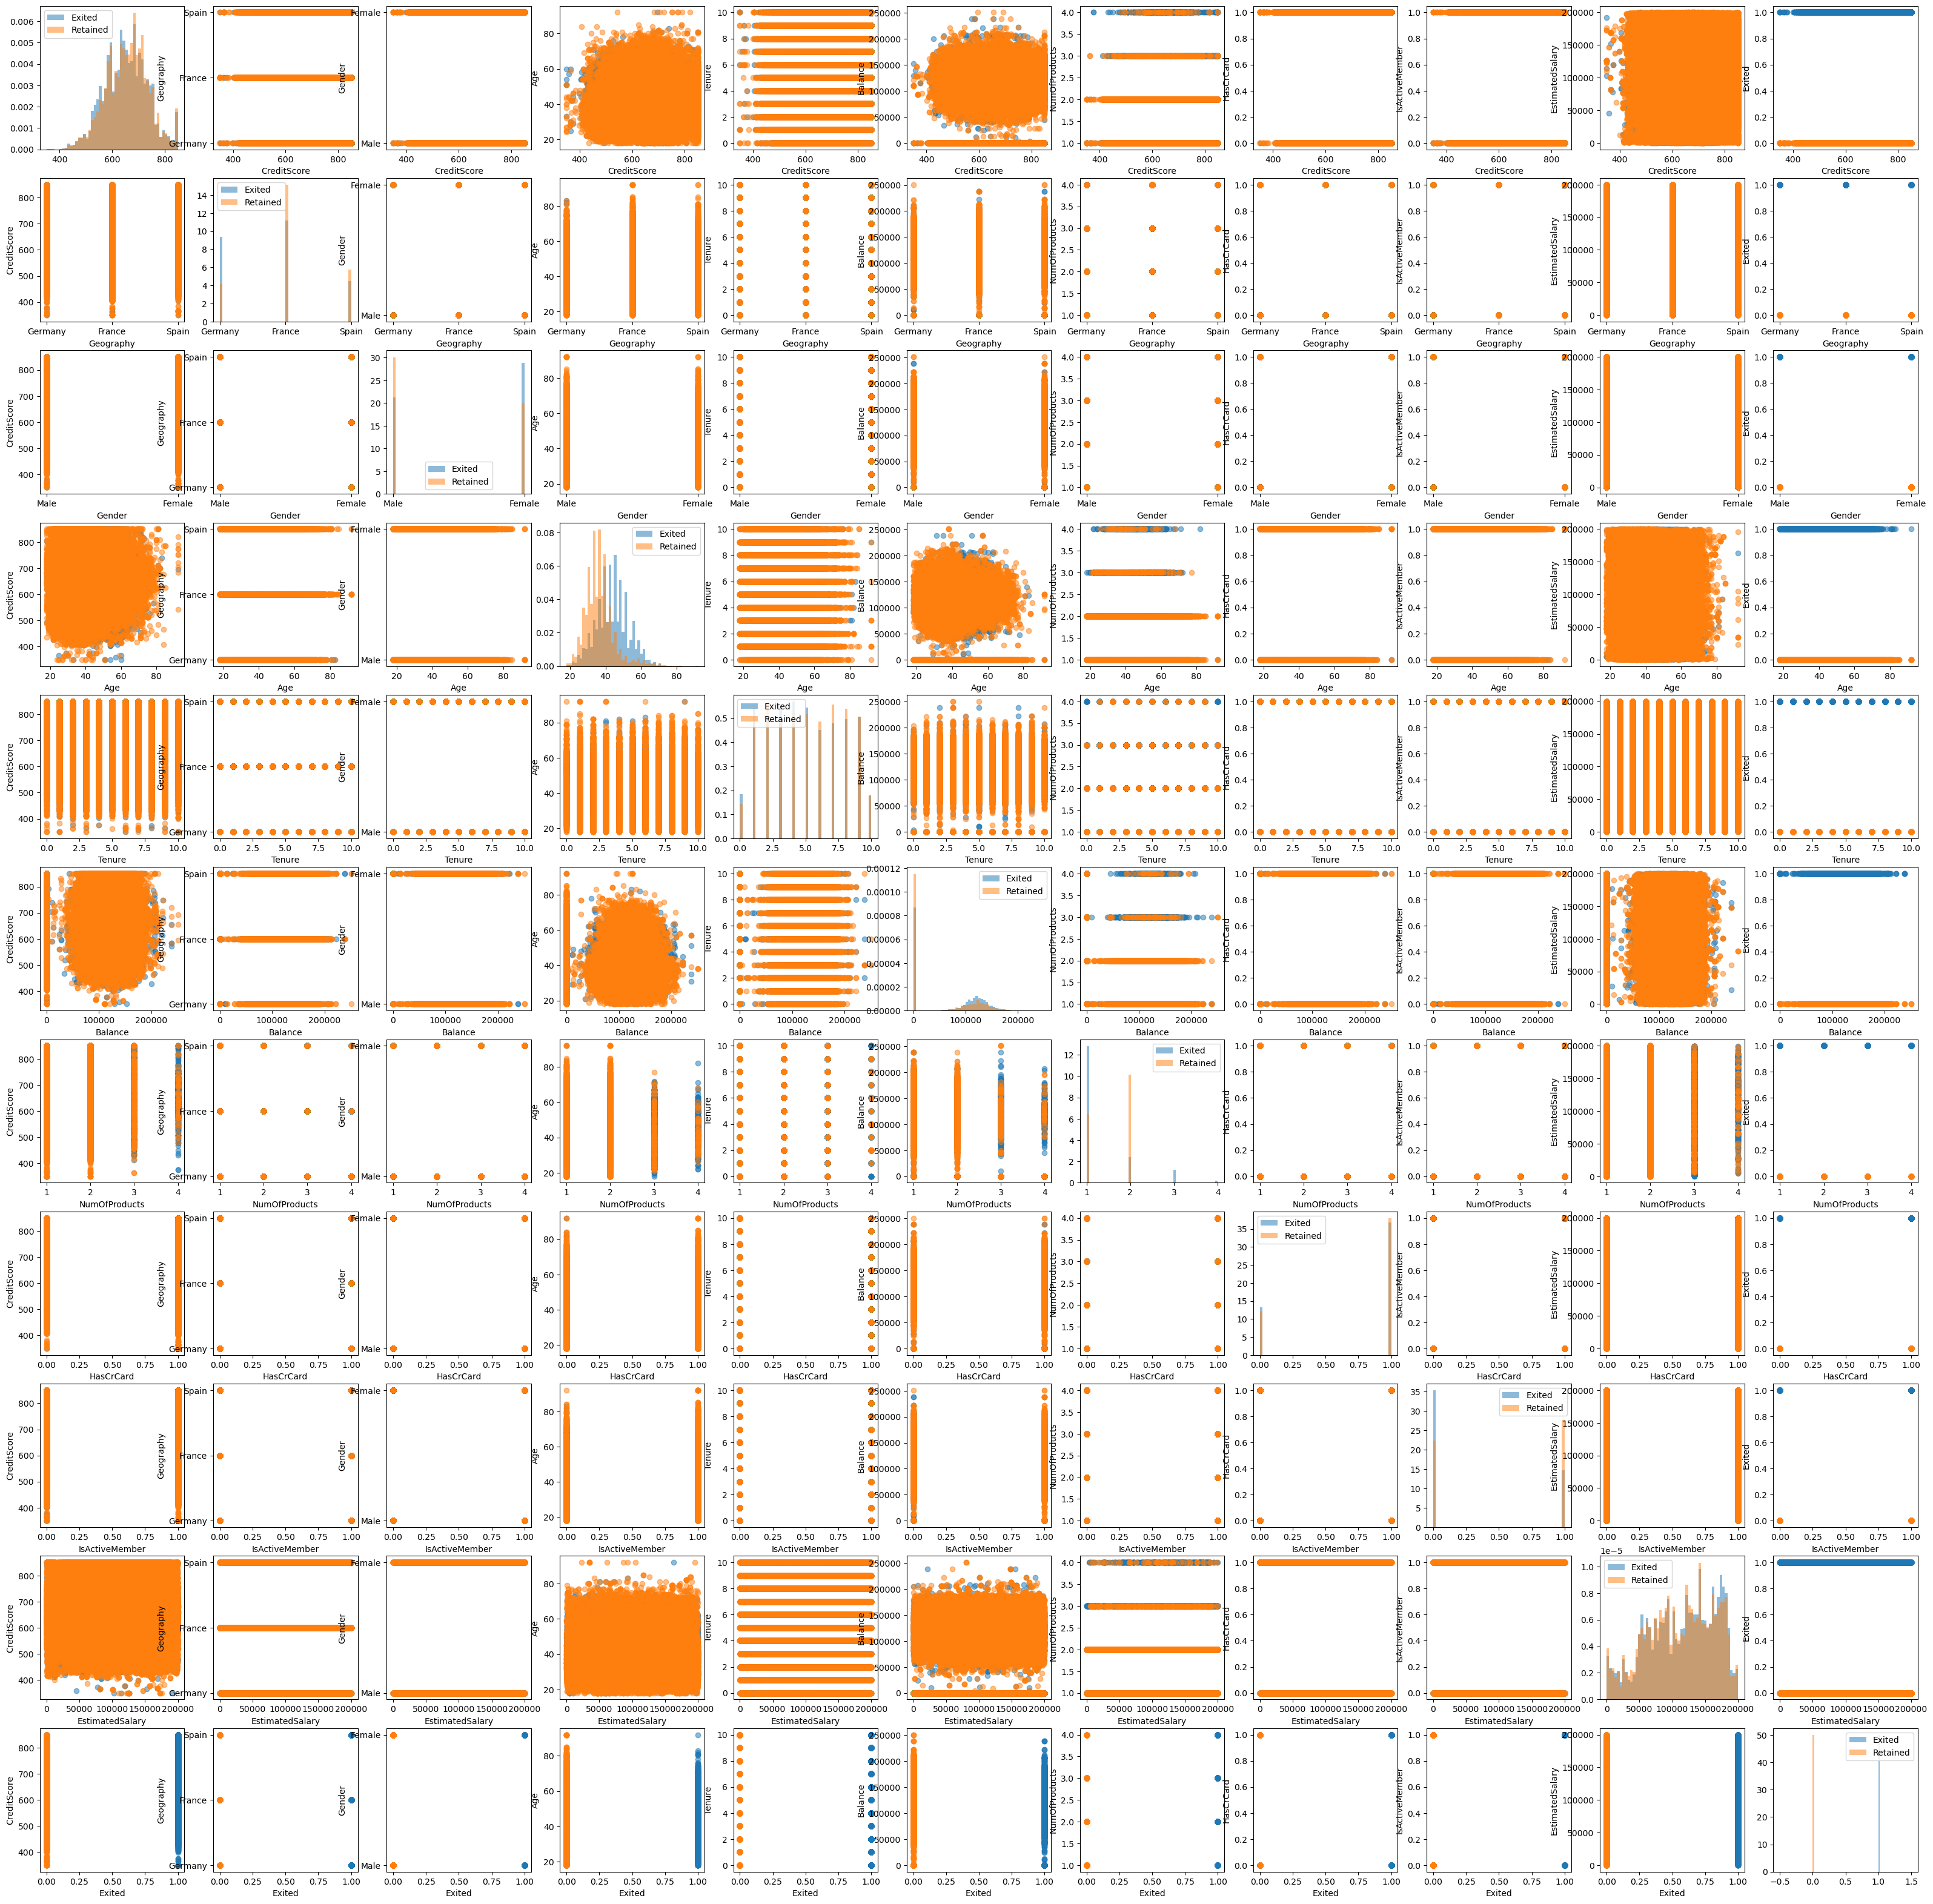

In [16]:
#pair plots
selection_dict={'Exited':df['Exited']==1,'Retained':df['Exited']==0} #label/naming and telling that 0/1 means background/signal respectively
column_names=df.columns.to_list()
n_columns=len(column_names)
plt.figure(figsize=(40,40)) #setting up figure size

plot_i=0 #counter to allow for indexing for placement of subplots

#iterating and enumerating through variables
for i,x_var_name in enumerate(column_names):
    #another loop since plotting each variable against each other
    for j,y_var_name in enumerate(column_names):
        plot_i+=1 #increase counter for indexing
        plt.subplot(n_columns,n_columns,plot_i) #subplot layout is the number of features by number of features; 'plot_it' is the index
        make_legend = plot_i==1
        if i==j: #plots on the diagonal
            #plot histogram of feature instead of scatterplot of one feature against itself
            compare_distributions(df,x_var_name,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
        else:
            #when not on the diagonal, plot the scatter plot
            compare_scatter(df,x_var_name,y_var_name,selection_dict,make_legend=make_legend,alpha=0.5)


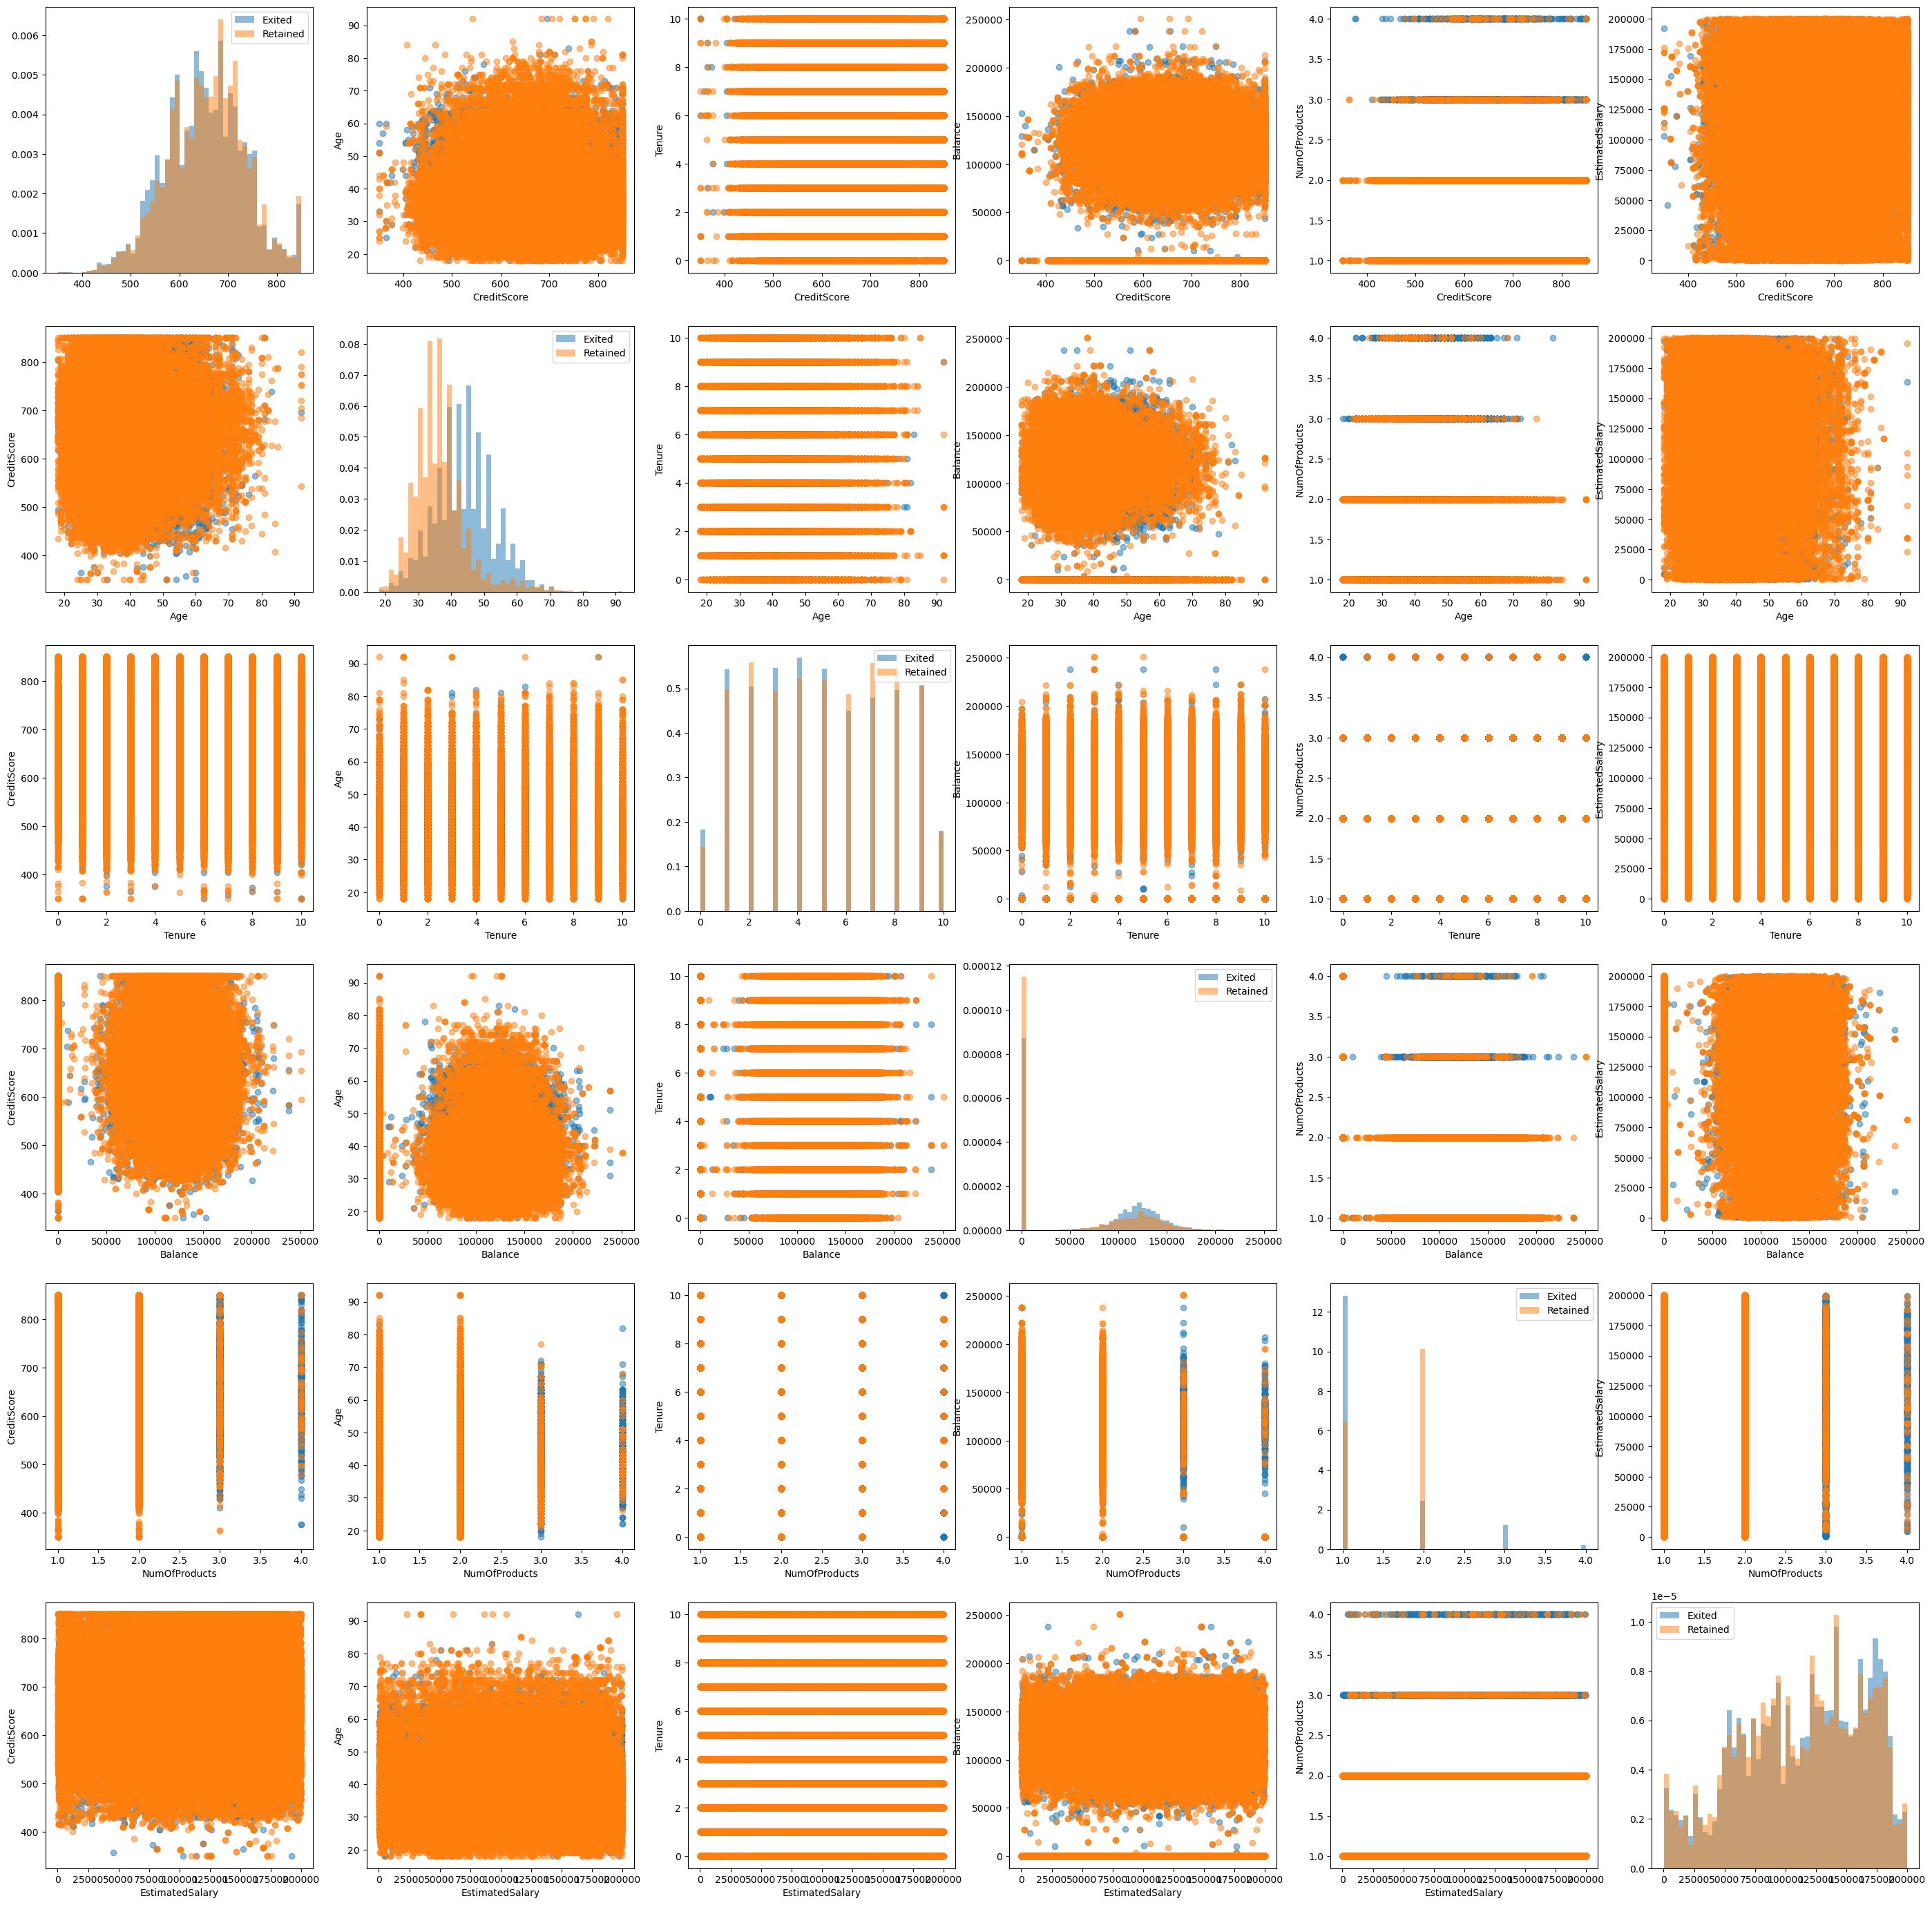

In [8]:
#pairplot; numerical columns only
num_cols=['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
selection_dict={'Exited':df['Exited']==1,'Retained':df['Exited']==0} #label/naming and telling that 0/1 means background/signal respectively
n_columns=len(num_cols)
plt.figure(figsize=(35,35)) #setting up figure size

plot_i=0 #counter to allow for indexing for placement of subplots

#iterating and enumerating through variables
for i,x_var_name in enumerate(num_cols):
    #another loop since plotting each variable against each other
    for j,y_var_name in enumerate(num_cols):
        plot_i+=1 #increase counter for indexing
        plt.subplot(n_columns,n_columns,plot_i) #subplot layout is the number of features by number of features; 'plot_it' is the index
        make_legend = plot_i==1
        if i==j: #plots on the diagonal
            #plot histogram of feature instead of scatterplot of one feature against itself
            compare_distributions(df,x_var_name,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
        else:
            #when not on the diagonal, plot the scatter plot
            compare_scatter(df,x_var_name,y_var_name,selection_dict,make_legend=make_legend,alpha=0.5)

- Took out features that were already labeled as categorical
- Easier to see that Tenure and NumOfProducts should be categorical instead of numerical given the columns of frequency instead of continuous distribution like CreditScore
- Of the correctly labeled numerical columns, only Age and Balance show some distinction between Exited status
    - Age: Exited distribution peaks at higher ages than Retained
    - Balance: Exited distribution has higher peak than Retained (Exited appears to have a higher concentration of data around the center of the balance distribution)
- From the Scatterplots, there does not appear to be any obvious linear/non-linear relationships between features

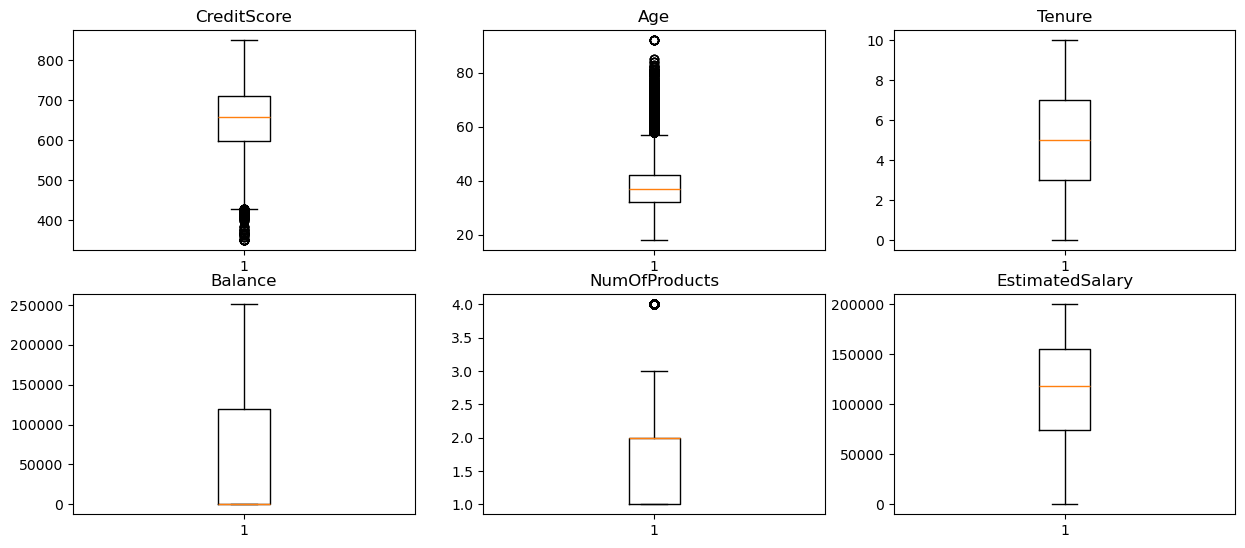

In [10]:
#looking at numerical columns as boxplots
count=1 #counter used for plotting boxplots

#figure size
plt.figure(figsize=(15,20))

#iterating through columns and plotting boxplot
for col in num_cols:
  plt.subplot(6,3,count)
  plt.boxplot(df[col])
  plt.title(col)
  count+=1
plt.show()

- Boxplots reflects what was shown previously in the summary table + .describe() table

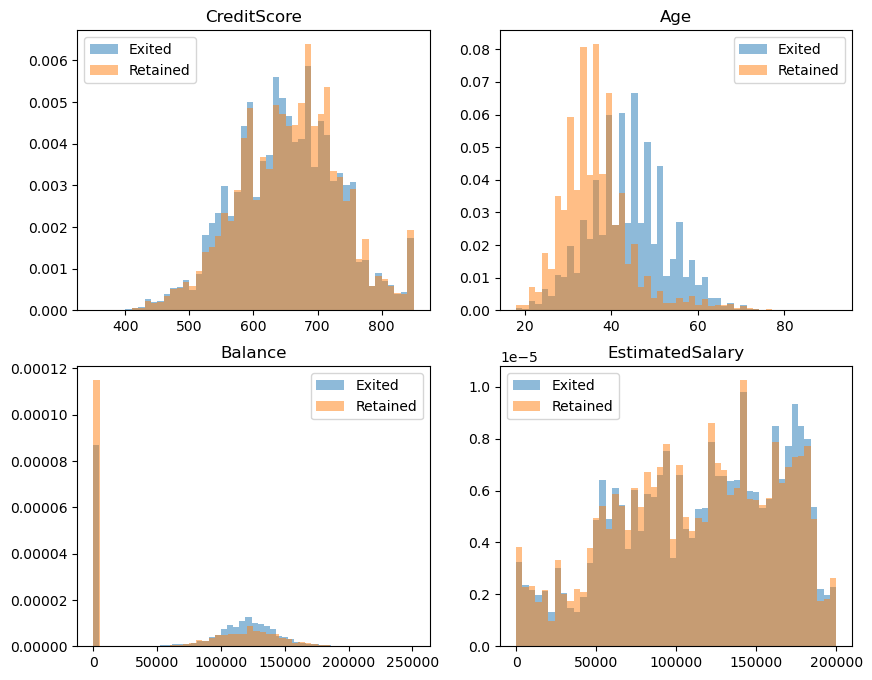

In [19]:
#histograms
selection_dict={'Exited':df['Exited']==1,'Retained':df['Exited']==0}
num_var=['CreditScore','Age','Balance','EstimatedSalary']

count=1 #counter used for plotting boxplots

#figure size
plt.figure(figsize=(10,8))

#iterating through columns and plotting boxplot
for col in num_var:
    plt.subplot(2,2,count)
    compare_distributions(df,col,
                     selection_dict,
                     alpha=0.5,
                     density=1,
                     bins=50,
                     )
    plt.title(col)
    count+=1
plt.show()

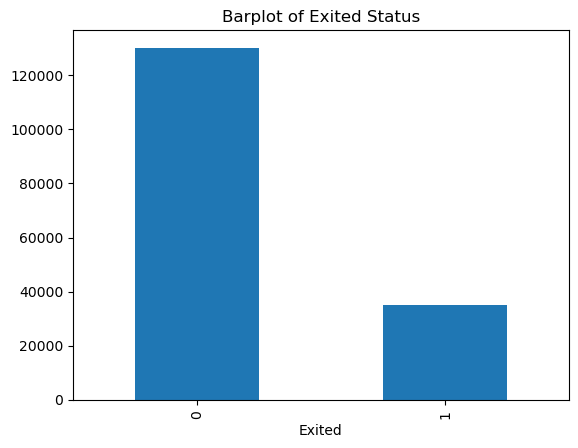

In [19]:
#looking at counts of Exited/Retained
df['Exited'].value_counts().plot(kind='bar')
plt.title('Barplot of Exited Status')
plt.show()

- Imbalanced dataset, need to keep in mind when looking at model metrics

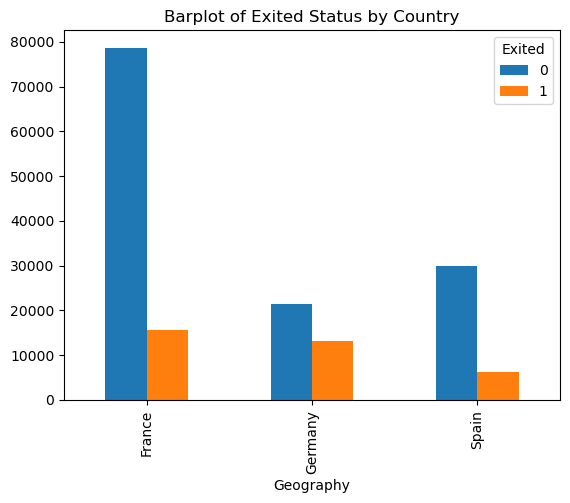

In [20]:
#looking at 'Exited' status by country
#looking at counts of Exited/Retained
dfc=df.groupby('Geography')
dfc['Exited'].value_counts().unstack().plot(kind='bar')
plt.title('Barplot of Exited Status by Country')
plt.show()

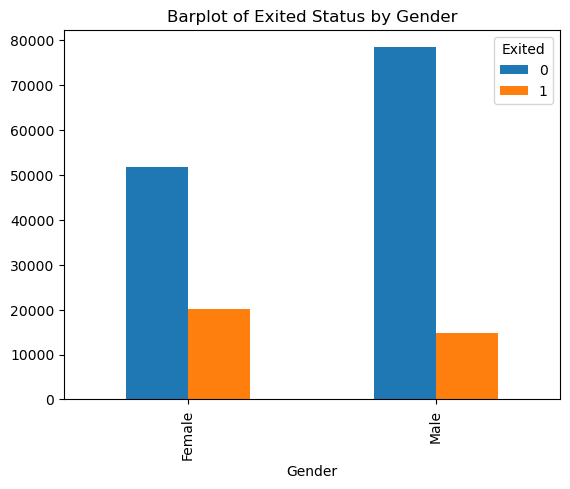

In [21]:
#looking at 'Exited' status by gender
#looking at counts of Exited/Retained
dfg=df.groupby('Gender')
dfg['Exited'].value_counts().unstack().plot(kind='bar')
plt.title('Barplot of Exited Status by Gender')
plt.show()

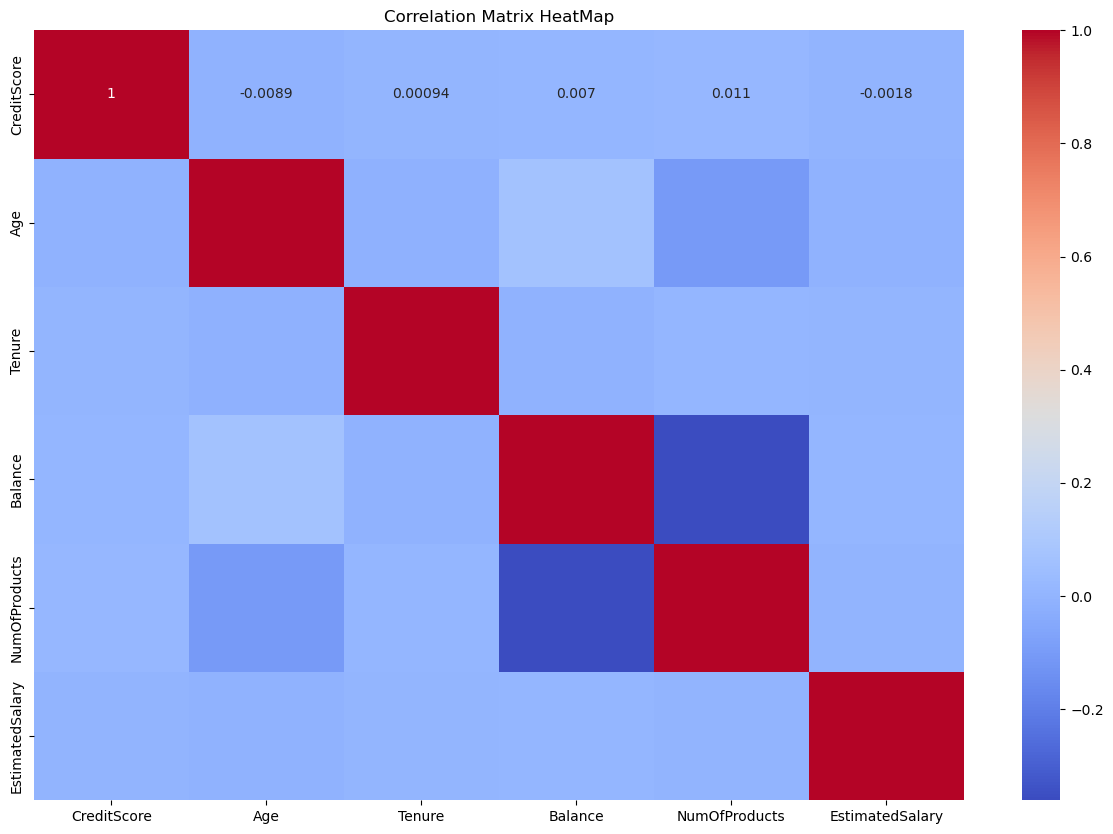

In [31]:
#Correlation
import seaborn as sns

corr_matrix=df[num_cols].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix HeatMap')
plt.show()

- Reflects what was understood from pairplot, features do not have strong correlation with one another such that multicollinearity becomes a worry

# Data Cleaning
- Dealing with outliers (method: impute 5/95 percentile)
- One Hot Encode all categorical features
- Normalize numerical features
- df that is ready to be used to train ML models
    - Steps done in this section will be wrapped into 'Churn_Preprocess.py' as a module to be used to quickly apply what was done in this notebook to the raw dataset

In [72]:
#function to deal with outliers in a dataset
def fix_outliers(dataset,col_lst):
  for col in col_lst:
    q1=dataset[col].quantile(0.25)
    q3=dataset[col].quantile(0.75)
    IQR=q3-q1
    lower=q1-(1.5*IQR)
    upper=q3+(1.5*IQR)
    p5=dataset[col].quantile(0.05)
    p95=dataset[col].quantile(0.95)
    dataset.loc[dataset[col]<lower,col]=p5
    dataset.loc[dataset[col]>upper,col]=p95
  return dataset

In [73]:
#dealing with outliers
need_fix=['CreditScore','Age'] #from table in Data Understanding section
df=fix_outliers(df,need_fix)

In [74]:
#seeing if fix has been applied
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.635602,37.844267,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,79.663154,8.091436,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,428.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,57.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## Feature Engineering

All new features will be numerical
- Age/Tenure Ratio
- Balance/Tenure Ratio
- Balance/Age Ratio

In [75]:
#creating new features
df['Age/Tenure']=df['Age']/df['Tenure']
df['Balance/Tenure']=df['Balance']/df['Tenure']
df['Balance/Age']=df['Balance']/df['Age']
df #checking if new columns were made

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age/Tenure,Balance/Tenure,Balance/Age
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,11.000000,0.000000,0.000000
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,33.000000,0.000000,0.000000
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,4.000000,0.000000,0.000000
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,17.000000,74441.270000,4378.898235
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,6.600000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,16.500000,0.000000,0.000000
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,11.666667,0.000000,0.000000
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,6.200000,0.000000,0.000000
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,4.285714,23076.142857,5384.433333


In [76]:
#checking for null values after feature engineering 
#expecting some due to division by Tenure which contains 0
df.isnull().sum()

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Age/Tenure            0
Balance/Tenure     2461
Balance/Age           0
dtype: int64

In [77]:
df.isin([np.inf, -np.inf]).sum()

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Age/Tenure         5007
Balance/Tenure     2546
Balance/Age           0
dtype: int64

In [81]:
#imputing 0 where there are NAs or inf values
df=df.replace([np.nan,np.inf,-np.inf], 0)

In [82]:
#checking that NAs were dealt with
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Age/Tenure         0
Balance/Tenure     0
Balance/Age        0
dtype: int64

In [83]:
#checking that inf values were dealt with
df.isin([np.inf, -np.inf]).sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Age/Tenure         0
Balance/Tenure     0
Balance/Age        0
dtype: int64

## Encoding/Normalization

In [84]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [85]:
#one hot encoding categorical columns
cat_varnames=['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
encoder=OneHotEncoder()
encoder.fit(df[cat_varnames])
encoded = pd.DataFrame(encoder.transform(df[cat_varnames]).toarray())

In [86]:
#checking encoding
encoded

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
165030,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
165031,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
165032,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [87]:
#normalizing numerical columns
nums=df.drop(columns=cat_varnames)
nums=nums.drop(columns='Exited') #also dropping target var
scaler=MinMaxScaler()
nums=pd.DataFrame(scaler.fit_transform(nums),
                  columns=['CreditScore','Age','Balance','EstimatedSalary','Age/Tenure','Balance/Tenure','Balance/Age'])

In [88]:
#checking normalization
nums

,CreditScore,Age,Balance,EstimatedSalary,Age/Tenure,Balance/Tenure,Balance/Age
0,0.568720,0.384615,0.000000,0.907279,0.192982,0.000000,0.000000
1,0.471564,0.384615,0.000000,0.247483,0.578947,0.000000,0.000000
2,0.592417,0.564103,0.000000,0.924364,0.070175,0.000000,0.000000
3,0.362559,0.410256,0.593398,0.422787,0.298246,0.336028,0.424012
4,0.682464,0.384615,0.000000,0.075293,0.115789,0.000000,0.000000
...,...,...,...,...,...,...,...
165029,0.566351,0.384615,0.000000,0.659179,0.289474,0.000000,0.000000
165030,0.862559,0.435897,0.000000,0.659177,0.204678,0.000000,0.000000
165031,0.324645,0.333333,0.000000,0.637151,0.108772,0.000000,0.000000
165032,0.298578,0.307692,0.643819,0.355841,0.075188,0.104166,0.521378


In [89]:
#recombining numerical and categorical 
df=pd.concat([nums,encoded,df['Exited']],axis=1)

In [90]:
#checking dataset
df.head()

,CreditScore,Age,Balance,EstimatedSalary,Age/Tenure,Balance/Tenure,Balance/Age,0,1,2,...,15,16,17,18,19,20,21,22,23,Exited
0,0.568720,0.384615,0.000000,0.907279,0.192982,0.000000,0.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,0.471564,0.384615,0.000000,0.247483,0.578947,0.000000,0.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,0.592417,0.564103,0.000000,0.924364,0.070175,0.000000,0.000000,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,0.362559,0.410256,0.593398,0.422787,0.298246,0.336028,0.424012,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,0.682464,0.384615,0.000000,0.075293,0.115789,0.000000,0.000000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
